In [1]:
import torch
torch.manual_seed(123)
import random
random.seed(123)

import torch.nn as nn
import os
import shutil
import itertools
import sklearn.cluster

from chofer_torchex.utils.functional import collection_cascade, cuda_cascade

from chofer_tda_datasets import SciNe01EEGBottomTopFiltration
from chofer_tda_datasets.transforms import Hdf5GroupToDictSelector

from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, \
SLayerRational, \
LinearRationalStretchedBirthLifeTimeCoordinateTransform, \
prepare_batch, SLayerRationalHat
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable


%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(3)


class train_env:
    nu = 0.1
    n_epochs = 200
    lr_initial = 0.5
    momentum = 0.9
    lr_epoch_step = 20
    batch_size = 100
    train_size = 0.9
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)

dataset = SciNe01EEGBottomTopFiltration(data_root_folder_path='/scratch1/chofer/jmlr2018_data/')
sensor_indices = [str(i) for i in dataset.sensor_configurations['low_resolution_whole_head']]
selection = {'top': sensor_indices, 'bottom': sensor_indices}
selector = Hdf5GroupToDictSelector(selection)

dataset.data_transforms = [
                           selector,
                           numpy_to_torch_cascade,                              
                           lambda x: collection_cascade(x, 
                                                        lambda x: isinstance(x, torch._TensorBase), 
                                                        lambda x: coordinate_transform(x)),
                           ]

dataset.target_transforms = [lambda x: int(x)]

/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def concat_scine01_sample_target_iter(sample_target_iter):
    x, y = defaultdict(lambda: defaultdict(list)), []
        
    for x_i, y_i in sample_target_iter:
        y.append(y_i)

        for k, v in x_i.items():
            for kk, dgm in v.items():
                x[k][kk].append(dgm)    

    return x, y


class Scine01Collate:   
    def __init__(self, cuda=True):
        self.cuda = cuda
        
    def __call__(self, sample_target_iter):
        x, y = concat_scine01_sample_target_iter(sample_target_iter)

        y = torch.LongTensor(y)    
        
        x = collection_cascade(x,
                           lambda xx: isinstance(xx, list),
                           lambda xx: prepare_batch(xx, 2)) 
        
        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = collection_cascade(x,
                                   lambda xx: isinstance(xx, tuple),
                                  lambda xx: (xx[0].cuda(), xx[1].cuda(), xx[2], xx[3]))
            y = y.cuda()

        return x, y                       
    
collate_fn = Scine01Collate(cuda=False)

In [3]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=10, exponent=1)

def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU(),
                     )
    m.out_features = m[0].out_features
    return m


class Scine01Model(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 25
        
        self.slayers = ModuleDict()
        for k, indices in selection.items():
            self.slayers[k] = ModuleDict()
            for kk in indices:
                s = Slayer(self.n_elements)
                self.slayers[k][kk] = nn.Sequential(s
                                                   )    
            
        cls_in_dim = self.n_elements * 2 * len(sensor_indices)
        n_1 = 2*cls_in_dim
        print('cls_in_dim', cls_in_dim)
        self.cls = nn.Sequential(
                                nn.Dropout(0.01), 
                                LinearCell(cls_in_dim, n_1),
                                LinearCell(n_1, int(n_1/4)),    
#                                 LinearCell(int(n_1/4), int(n_1/16)),   
#                                 nn.Dropout(0.1),
                                nn.Linear(int(n_1/4), 7))
        
    def forward(self, input):
        x = []
        for k, v in input.items():
            for kk, dgm in v.items():            
                x.append(self.slayers[k][kk](dgm))
        x = torch.cat(x, dim=1)          
        x = self.cls(x)       
                                              
        return x
    
    def center_init(self, sample_target_iter):        
        
        #reducing number of samples for initalization becaus of run-time reasons
#         n_samples = int(len(sample_target_iter)/1000)
#         sample_target_iter_reduced = list(sample_target_iter)[:n_samples]        
        
        x, _ = concat_scine01_sample_target_iter(sample_target_iter)
        
        def prepare_for_knn(samples):
            samples = torch.cat(samples, dim=0)
            samples = list({tuple(row) for row in samples})
            samples = np.array(samples)
            return samples              
        
        x = collection_cascade(x, stop_predicate=lambda e: isinstance(e, list), 
                                  function_to_apply=prepare_for_knn) 
        
        for k, v in x.items():
            for kk, dgm in v.items():                  
                kmeans = sklearn.cluster.KMeans(n_clusters=self.n_elements, init='k-means++', random_state=123, n_init=1)                           
                kmeans.fit(dgm)
                centers = kmeans.cluster_centers_
                centers = torch.from_numpy(centers).float()
                self.slayers[k][kk][0].centers.data = centers

In [4]:
stats_of_runs = []
def experiment():   
    
    splitter = StratifiedShuffleSplit(n_splits=10, 
                                      train_size=train_env.train_size, 
                                      test_size=1-train_env.train_size, 
                                      random_state=123)
    train_test_splits = list(splitter.split(X=dataset.targets, y=dataset.targets))
    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)     

        model = Scine01Model()
#         model.center_init([dataset[i] for i in train_i])
        model.cuda()

        stats = defaultdict(list)
        stats_of_runs.append(stats)
        
        opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
            train_sampler = [i for i in train_i]
            random.shuffle(train_sampler)
            dl_train = DataLoader(dataset,
                              batch_size=train_env.batch_size, 
                              collate_fn=collate_fn,
                              sampler=train_sampler, 
                              num_workers=10)

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=collate_fn, 
                                 sampler=test_i,
                                 num_workers=10)

            epoch_loss = 0    

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):    
                
                x = collection_cascade(x,
                                       lambda xx: isinstance(xx, tuple),
                                       lambda xx: (xx[0].cuda(), xx[1].cuda(), xx[2], xx[3]))
                y = y.cuda()

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.slayers['top'][sensor_indices[0]][0].centers.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))            
                     
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            confusion_matrix = np.zeros((7, 7))
            
            for i_batch, (x, y) in enumerate(dl_test):
                
                x = collection_cascade(x,
                                       lambda xx: isinstance(xx, tuple),
                                       lambda xx: (xx[0].cuda(), xx[1].cuda(), xx[2], xx[3]))
                y = y.cuda()

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)
                
                y_hat = y_hat.max(dim=1)[1].data.long()
                
                for y_i_true, y_i_pred in zip(y, y_hat):
                    confusion_matrix[y_i_true, y_i_pred] += 1

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            stats['test_accuracy'].append(true_samples/seen_samples)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
            stats['confusion_matrix'] = confusion_matrix
            print('')
            print(true_samples/seen_samples)
            
        print('')
        print('acc.', np.mean(stats['test_accuracy'][-10:]))
#     return stats_of_runs

experiment()
# stats_of_runs = experiment()


Run 0
cls_in_dim 1000
Epoch 1/200, Batch 284/284       
0.21714285714285714


Process Process-28:
Process Process-22:
Process Process-21:
Process Process-23:
Process Process-30:
Process Process-24:
Process Process-27:
Process Process-25:
Process Process-26:
Process Process-29:
Traceback (most recent call last):
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 59, in _worker_loop
    data_queue.put((idx, samples))
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 346, in put
    with self._wlock:
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/scratch2/chof

KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6

  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/_hl/dataset.py", line 476, in __getitem__
    selection = sel.select(self.shape, args, dsid=self.id)
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/_hl/selections.py", line 94, in select
    sel[args]
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/_hl/dataset.py", line 325, in __init__
    self._dcpl = self.id.get_create_plist()
  File "h5py/h5o.pyx", line 190, in h5py.h5

Traceback (most recent call last):
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-8ee2feb1fddc>", line 107, in <module>
    experiment()
  File "<ipython-input-4-8ee2feb1fddc>", line 47, in experiment
    for i_batch, (x, y) in enumerate(dl_train, 1):
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 275, in __next__
    idx, batch = self._get_batch()
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 254, in _get_batch
    return self.data_queue.get()
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    f

KeyboardInterrupt: 

In [ ]:
print(np.mean([np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]))
[np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]

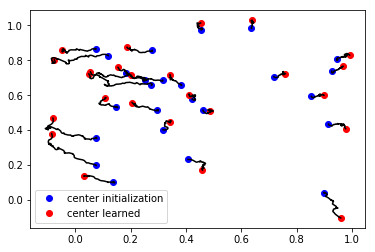

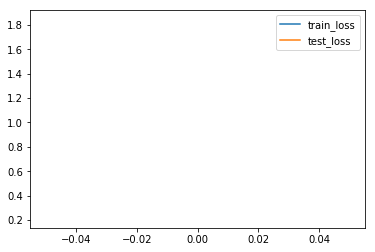

In [5]:
plt.figure()
stats = stats_of_runs[0]
c_start = stats['centers'][0]
c_end = stats['centers'][-1]

plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

all_centers = numpy.stack(stats['centers'], axis=0)
for i in range(all_centers.shape[1]):
    points = all_centers[:,i, :]
    plt.plot(points[:, 0], points[:, 1], '-k')
    
plt.legend()

plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'])


plt.legend()
plt.show()

In [ ]:
data_set = SciNe01EEGBottomTopFiltration(data_root_folder_path='../chofer_tda_datasets/data_generated/')
indices = [str(i) for i in data_set.sensor_configurations['all']]
selector = Hdf5GroupToDictSelector({'top': indices, 'bottom': indices})
data_set.data_transforms.append(selector)